In [1]:
# Class dependencies
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import torch
from models.folds import Fold, SoftFold
from models.model_bank import DynamicOrigami
from models.training import train, NoamScheduler, load_data
from torch.utils.data import Dataset, DataLoader



# Other analysis libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from sklearn.datasets import load_digits

In [2]:
# import small digits dataset
digits = load_digits()
X = digits.data
y = digits.target

# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

# set up the model
# model = OrigamiNetwork(layers=1, epochs=300, optimizer='sgd',learning_rate=0.001, sigmoid=True, crease=5)
# model.fit(X_train, y_train, X_val, y_val)

# # get the predictions
# y_hat = model.predict(X_test)
# print(accuracy_score(y_test, y_hat))

In [3]:
architecture = [{'type': 'SoftFold', 'params': {'width': 64, 'has_stretch': True}},
                {'type': 'Linear', 'params': {'in_features': 64, 'out_features': 120}},
                {'type': 'SoftFold', 'params': {'width': 120, 'has_stretch': True}},
                {'type': 'Linear', 'params': {'in_features': 120, 'out_features': 400}},
                {'type': 'SoftFold', 'params': {'width': 400, 'has_stretch': True}},
                {'type': 'Linear', 'params': {'in_features': 400, 'out_features': 50}},
                {'type': 'SoftFold', 'params': {'width': 60, 'has_stretch': True}},]

In [4]:
model = DynamicOrigami(architecture,10)
optimizer = torch.optim.Adam(model.parameters(), lr=.001)
train_loader = load_data(X_train, y_train, batch_size=32, shuffle=True)
val_loader = load_data(X_val, y_val, batch_size=32, shuffle=True)
test_loader = load_data(X_test, y_test, batch_size=32, shuffle=True)

In [5]:
train_losses, val_losses, train_accuracies, val_accuracies = train(model, optimizer, train_loader, val_loader, epochs=200)

Working Device: cpu


epoch:200/200, batch: 36/36, loss:0.0000: 100%|██████████| 7200/7200 [00:14<00:00, 508.13it/s]


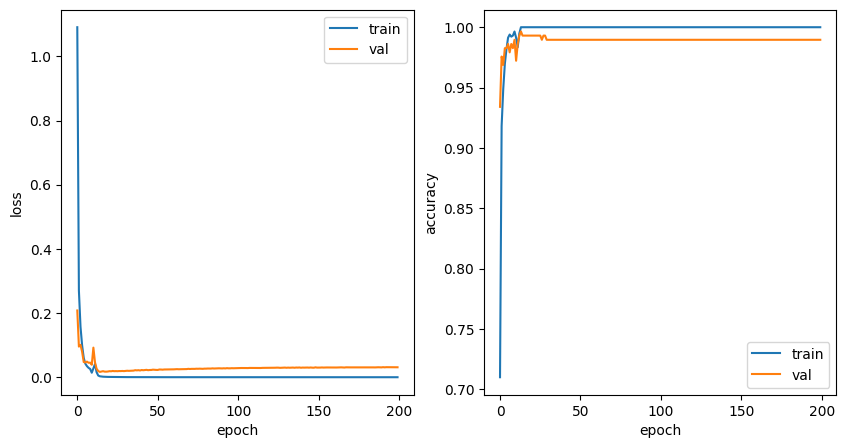

In [9]:
# plot the losses and accuracies
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='train')
plt.plot(val_accuracies, label='val')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [10]:
print(val_accuracies[-1])

0.9895833333333334


In [11]:
# print out all stretch and crease parameters
for layer in model.layers:
    if isinstance(layer, SoftFold):
        # print the layer number
        print(f'Layer {layer}')
        print(f'Crease: {layer.crease.data[0]}')
        print(f'Stretch: {layer.stretch.data}')
        print()

Layer SoftFold()
Crease: -0.0905224084854126
Stretch: 2.0546205043792725

Layer SoftFold()
Crease: -0.9749071002006531
Stretch: 2.0770111083984375

Layer SoftFold()
Crease: -0.8522852063179016
Stretch: 2.054605722427368

Layer SoftFold()
Crease: -1.657487392425537
Stretch: 2.0515480041503906

